### Notebook para testar o modelo treinado com o dataset completo de 7.3k questoes
Nesse caderno, vamos carregar o modelo treinado com o dataset completo de 1k questoes e testar sua performance em questoes que ainda nao foram anotadas manualmente. Dessa forma, podemos avaliar a capacidade do modelo de generalizar para novos dados e identificar areas onde ele pode precisar de melhorias adicionais.


In [31]:
import pandas as pd
import numpy as np
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Configurar estilo dos graficos
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

print("TESTE COMPLETO DO MODELO 1K - TODO O DATASET ENEM NAO ANOTADO")
print("=" * 70)
print("Escopo: ~6.000 questoes nao anotadas para analise robusta")
print("Objetivo: Avaliacao completa da performance em dados reais")
print("=" * 70)

TESTE COMPLETO DO MODELO 1K - TODO O DATASET ENEM NAO ANOTADO
Escopo: ~6.000 questoes nao anotadas para analise robusta
Objetivo: Avaliacao completa da performance em dados reais


In [32]:
# --- 1. CARREGAR O MODELO 1K FINAL ---

print("Carregando o modelo 1K final...")

model_path = "/Users/giossaurus/Developer/leia_tcc/models/leia_classifier_1k_final"
model = AutoModelForSequenceClassification.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)

# Obter configuracao do modelo
id2label = model.config.id2label
label2id = model.config.label2id

print(f"Modelo carregado de: {model_path}")
print(f"Categorias disponiveis: {list(id2label.values())}")
print(f"Mapeamento: {label2id}")

Carregando o modelo 1K final...
Modelo carregado de: /Users/giossaurus/Developer/leia_tcc/models/leia_classifier_1k_final
Categorias disponiveis: ['Análise de Exemplo', 'Conceitual', 'Procedimental', 'Comparativo']
Mapeamento: {'Análise de Exemplo': 0, 'Comparativo': 3, 'Conceitual': 1, 'Procedimental': 2}


In [33]:
# --- 2. CARREGAR E PREPARAR O DATASET COMPLETO ---

print("\nCarregando dataset completo dos simulados ENEM...")

# Carregar o dataset completo
df_completo = pd.read_csv('/Users/giossaurus/Developer/leia_tcc/data/interim/simulados_enem_completo.csv')

print(f"Dataset original: {len(df_completo)} questoes")
print(f"Colunas disponiveis: {df_completo.columns.tolist()}")

# Verificar as primeiras linhas
print("\nPrimeiras 3 linhas do dataset:")
print(df_completo.head(3))

# Verificar se ha dados faltantes na coluna question
missing_questions = df_completo['question'].isna().sum()
print(f"\nQuestoes com texto faltante: {missing_questions}")

# Filtrar apenas questoes com texto valido
df_completo_clean = df_completo.dropna(subset=['question']).copy()
df_completo_clean = df_completo_clean[df_completo_clean['question'].str.strip() != ''].copy()

print(f"Dataset limpo: {len(df_completo_clean)} questoes validas")
print(f"Questoes removidas: {len(df_completo) - len(df_completo_clean)}")


Carregando dataset completo dos simulados ENEM...
Dataset original: 7357 questoes
Colunas disponiveis: ['question', 'true_answer', 'question_id', 'dataset', 'split']

Primeiras 3 linhas do dataset:
                                            question          true_answer  \
0  TEXTO DE REFERÊNCIA: Nos desfiles das escolas ...                36 m²   
1  TEXTO DE REFERÊNCIA: A companhia de energia el...      V(x) = 3x – 288   
2  TEXTO DE REFERÊNCIA: A forma mais simples e an...  hidratação do eteno   

                                         question_id               dataset  \
0  512bec889180958c6b2e1c395931312ecc916a2039930d...            Matemática   
1  15da8d828a79fd53c164ac141d0ff2da49b16ade1618ae...            Matemática   
2  511f342e3329057bc6c74ff0f0c36dae381f437c3d5350...  Ciências da Natureza   

   split  
0  train  
1  train  
2  train  

Questoes com texto faltante: 0
Dataset limpo: 7357 questoes validas
Questoes removidas: 0


In [35]:
# --- 3. FILTRAR QUESTOES NAO ANOTADAS ---

print("\nIdentificando questoes nao anotadas...")

# Carregar todas as questoes que ja foram anotadas manualmente
anotated_files = [
    '/Users/giossaurus/Developer/leia_tcc/data/processed/seed_set_anotado.csv',
    '/Users/giossaurus/Developer/leia_tcc/data/processed/active_learning_cycle1.csv',
    '/Users/giossaurus/Developer/leia_tcc/data/processed/active_learning_cycle2.csv',
    '/Users/giossaurus/Developer/leia_tcc/data/processed/anotacao_maior_final.csv'
]

anotated_question_ids = set()

for file_path in anotated_files:
    try:
        df_temp = pd.read_csv(file_path)
        if 'question_id' in df_temp.columns:
            ids = df_temp['question_id'].dropna().astype(str).tolist()
            anotated_question_ids.update(ids)
            print(f" {file_path.split('/')[-1]}: {len(ids)} IDs unicos")
    except Exception as e:
        print(f"Erro ao carregar {file_path}: {e}")

print(f"\nTotal de questoes ja anotadas: {len(anotated_question_ids)}")

# Filtrar questoes nao anotadas do dataset completo
df_completo_clean['question_id_str'] = df_completo_clean['question_id'].astype(str)
df_nao_anotadas = df_completo_clean[~df_completo_clean['question_id_str'].isin(anotated_question_ids)].copy()

print(f"Questoes nao anotadas disponiveis: {len(df_nao_anotadas)}")
print(f"Percentual do dataset nao anotado: {len(df_nao_anotadas)/len(df_completo_clean)*100:.1f}%")


Identificando questoes nao anotadas...
 seed_set_anotado.csv: 200 IDs unicos
 active_learning_cycle1.csv: 50 IDs unicos
 active_learning_cycle2.csv: 50 IDs unicos
 anotacao_maior_final.csv: 701 IDs unicos

Total de questoes ja anotadas: 1001
Questoes nao anotadas disponiveis: 6356
Percentual do dataset nao anotado: 86.4%


In [36]:
# --- 4. USAR TODAS AS QUESTOES NAO ANOTADAS PARA TESTE ---

print("\\nUsando TODAS as questoes nao anotadas para teste...")

# Usar TODO o dataset nao anotado para uma analise completa
print(f"Total de questoes nao anotadas disponiveis: {len(df_nao_anotadas)}")
print("Decisao: Usar TODOS os dados para analise mais robusta")

# Verificar se ha coluna dataset (equivalente a disciplina)
if 'dataset' in df_nao_anotadas.columns:
    print("\\nDistribuicao completa por area de conhecimento:")
    dataset_counts = df_nao_anotadas['dataset'].value_counts()
    print(dataset_counts)
    print(f"\\nTotal de areas representadas: {len(dataset_counts)}")
    # Renomear para facilitar analise
    df_nao_anotadas['disciplina'] = df_nao_anotadas['dataset']

# Usar todo o dataset nao anotado
df_teste = df_nao_anotadas.copy()

print(f"\\nESCOPO COMPLETO DO TESTE:")
print(f"   • Questoes para classificacao: {len(df_teste):,}")
print(f"   • Representatividade: {len(df_teste)/len(df_completo_clean)*100:.1f}% do dataset total")
print(f"   • Vantagens: Estatisticas mais robustas e cobertura completa")

if 'disciplina' in df_teste.columns:
    print(f"   • Areas cobertas: {df_teste['disciplina'].nunique()}")
    print("\\nDistribuicao final por area:")
    for area, count in df_teste['disciplina'].value_counts().items():
        percentage = (count / len(df_teste)) * 100
        print(f"     {area}: {count:,} questoes ({percentage:.1f}%)")

# Preparar dados para o modelo
df_teste['text'] = df_teste['question'].copy()

# IMPORTANTE: Garantir que o Dataset carregue TODOS os dados
print(f"\\nPreparando dataset com TODOS os {len(df_teste):,} exemplos...")
teste_dataset = Dataset.from_pandas(df_teste[['text']])

# Verificar se o dataset foi carregado corretamente
print(f" Dataset criado com: {len(teste_dataset):,} exemplos")
print(f"Tempo estimado de processamento: ~{len(teste_dataset)//100} minutos")

if len(teste_dataset) != len(df_teste):
    print(f"AVISO: Dataset truncado! Esperado: {len(df_teste)}, Atual: {len(teste_dataset)}")
else:
    print("Dataset completo carregado com sucesso!")

\nUsando TODAS as questoes nao anotadas para teste...
Total de questoes nao anotadas disponiveis: 6356
Decisao: Usar TODOS os dados para analise mais robusta
\nDistribuicao completa por area de conhecimento:
dataset
Ciências da Natureza    1771
Ciências Humanas        1682
Linguagens e Códigos    1501
Matemática              1402
Name: count, dtype: int64
\nTotal de areas representadas: 4
\nESCOPO COMPLETO DO TESTE:
   • Questoes para classificacao: 6,356
   • Representatividade: 86.4% do dataset total
   • Vantagens: Estatisticas mais robustas e cobertura completa
   • Areas cobertas: 4
\nDistribuicao final por area:
     Ciências da Natureza: 1,771 questoes (27.9%)
     Ciências Humanas: 1,682 questoes (26.5%)
     Linguagens e Códigos: 1,501 questoes (23.6%)
     Matemática: 1,402 questoes (22.1%)
\nPreparando dataset com TODOS os 6,356 exemplos...
 Dataset criado com: 6,356 exemplos
Tempo estimado de processamento: ~63 minutos
Dataset completo carregado com sucesso!


In [37]:
# --- 5. TOKENIZAR E FAZER PREDICOES ---

print("\nTokenizando dados...")

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=512)

tokenized_teste_dataset = teste_dataset.map(tokenize_function, batched=True)

print("Tokenizacao concluida")

print("\nExecutando predicoes no dataset completo...")

# Criar trainer apenas para predicoes
trainer = Trainer(model=model)

# Fazer predicoes
predictions_output = trainer.predict(tokenized_teste_dataset)
logits = predictions_output.predictions

# Converter para probabilidades e obter predicoes finais
probabilities = torch.nn.functional.softmax(torch.from_numpy(logits), dim=-1).numpy()
predicted_class_ids = np.argmax(probabilities, axis=1)
confidence_scores = np.max(probabilities, axis=1)

# Mapear IDs para labels
predicted_labels = [id2label[class_id] for class_id in predicted_class_ids]

print("Predicoes concluidas!")
print(f"{len(predicted_labels)} questoes classificadas")


Tokenizando dados...


Map:   0%|          | 0/6356 [00:00<?, ? examples/s]

Tokenizacao concluida

Executando predicoes no dataset completo...


KeyboardInterrupt: 

In [38]:
# --- 6. ANALISE DAS PREDICOES ---

print("\\nANALISE DAS PREDICOES NO DATASET COMPLETO")
print("=" * 60)

# Adicionar predicoes ao dataframe  
df_teste['predicted_label'] = predicted_labels
df_teste['predicted_class_id'] = predicted_class_ids
df_teste['confidence'] = confidence_scores

# Distribuicao das predicoes
print("\\nDISTRIBUICAO DAS PREDICOES:")
prediction_counts = Counter(predicted_labels)
total_predictions = len(predicted_labels)

# Garantir que todas as categorias sejam mostradas, mesmo com 0 predicoes
all_categories = list(id2label.values())
for categoria in all_categories:
    count = prediction_counts.get(categoria, 0)
    percentage = (count / total_predictions) * 100 if total_predictions > 0 else 0
    print(f"{categoria:20} | {count:4d} questoes ({percentage:5.1f}%)")

print(f"\\nESTATISTICAS DE CONFIANCA:")
print(f"Confianca media: {np.mean(confidence_scores):.3f}")
print(f"Confianca mediana: {np.median(confidence_scores):.3f}")
print(f"Confianca minima: {np.min(confidence_scores):.3f}")
print(f"Confianca maxima: {np.max(confidence_scores):.3f}")
print(f"Desvio padrao: {np.std(confidence_scores):.3f}")

# Predicoes por faixa de confianca
high_conf = np.sum(confidence_scores >= 0.8)
medium_conf = np.sum((confidence_scores >= 0.6) & (confidence_scores < 0.8))
low_conf = np.sum(confidence_scores < 0.6)

print(f"\\nDISTRIBUICAO POR CONFIANCA:")
print(f"Alta confianca (≥80%):   {high_conf:4d} questoes ({high_conf/total_predictions*100:5.1f}%)")
print(f"Media confianca (60-80%): {medium_conf:4d} questoes ({medium_conf/total_predictions*100:5.1f}%)")
print(f"Baixa confianca (<60%):   {low_conf:4d} questoes ({low_conf/total_predictions*100:5.1f}%)")

# Verificar se alguma categoria nao foi predita
categorias_nao_preditas = [cat for cat in all_categories if prediction_counts.get(cat, 0) == 0]
if categorias_nao_preditas:
    print(f"\\nCATEGORIAS NAO PREDITAS: {', '.join(categorias_nao_preditas)}")
    print("   Isso pode indicar:")
    print("   • Desbalanceamento do dataset de treino")
    print("   • Categoria pouco representativa no dominio ENEM")
    print("   • Necessidade de mais exemplos de treino para essas categorias")

\nANALISE DAS PREDICOES NO DATASET COMPLETO
\nDISTRIBUICAO DAS PREDICOES:
Análise de Exemplo   | 2864 questoes ( 45.1%)
Conceitual           | 1620 questoes ( 25.5%)
Procedimental        | 1872 questoes ( 29.5%)
Comparativo          |    0 questoes (  0.0%)
\nESTATISTICAS DE CONFIANCA:
Confianca media: 0.742
Confianca mediana: 0.757
Confianca minima: 0.334
Confianca maxima: 0.939
Desvio padrao: 0.137
\nDISTRIBUICAO POR CONFIANCA:
Alta confianca (≥80%):   2432 questoes ( 38.3%)
Media confianca (60-80%): 2738 questoes ( 43.1%)
Baixa confianca (<60%):   1186 questoes ( 18.7%)
\nCATEGORIAS NAO PREDITAS: Comparativo
   Isso pode indicar:
   • Desbalanceamento do dataset de treino
   • Categoria pouco representativa no dominio ENEM
   • Necessidade de mais exemplos de treino para essas categorias


Grafico salvo: distribuicao_predicoes_dataset_completo_6k.png


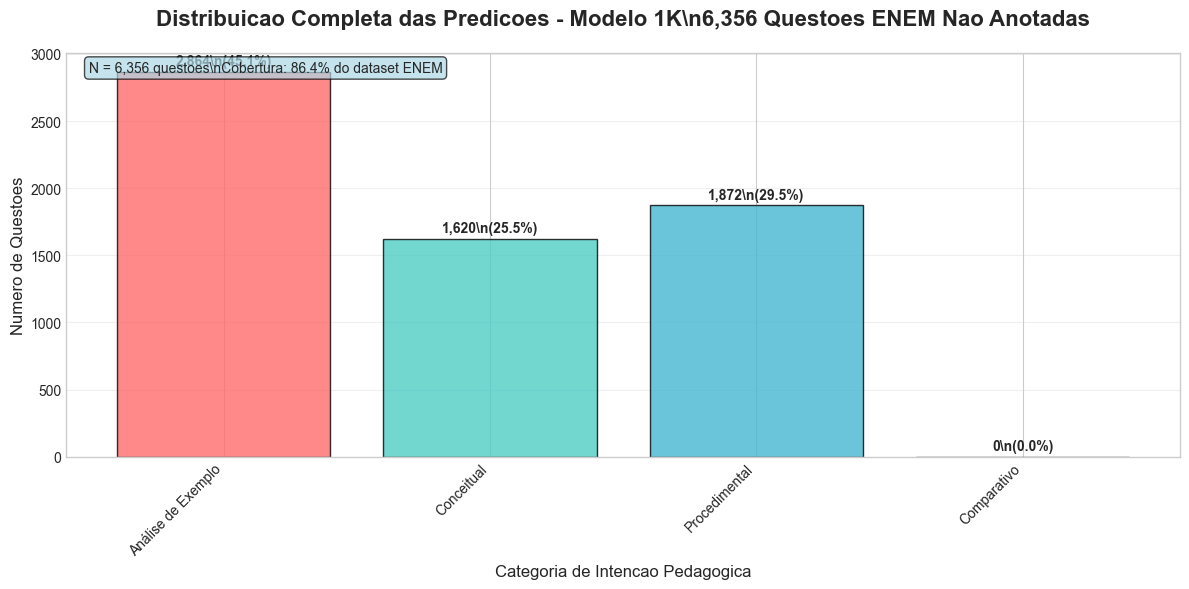

In [39]:
# --- 7. GRAFICO: DISTRIBUICAO COMPLETA DAS PREDICOES ---

# Grafico de barras da distribuicao das predicoes
plt.figure(figsize=(12, 6))

# Garantir que todas as categorias sejam incluidas, mesmo com 0 predicoes
all_categories = list(id2label.values())
labels = all_categories
counts = [prediction_counts.get(cat, 0) for cat in all_categories]
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']

bars = plt.bar(labels, counts, color=colors, alpha=0.8, edgecolor='black')

# Adicionar valores nas barras
for bar, count in zip(bars, counts):
    percentage = (count / total_predictions) * 100 if total_predictions > 0 else 0
    plt.text(bar.get_x() + bar.get_width()/2., bar.get_height() + max(max(counts), 1)*0.01,
             f'{count:,}\\n({percentage:.1f}%)', ha='center', va='bottom', fontweight='bold')

plt.title(f'Distribuicao Completa das Predicoes - Modelo 1K\\n{total_predictions:,} Questoes ENEM Nao Anotadas', 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Categoria de Intencao Pedagogica', fontsize=12)
plt.ylabel('Numero de Questoes', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)

# Adicionar informacao estatistica
plt.text(0.02, 0.98, f'N = {total_predictions:,} questoes\\nCobertura: {len(df_teste)/len(df_completo_clean)*100:.1f}% do dataset ENEM', 
         transform=plt.gca().transAxes, va='top', ha='left',
         bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.7))

plt.tight_layout()

# Salvar o grafico
plt.savefig('/Users/giossaurus/Developer/leia_tcc/results/distribuicao_predicoes_dataset_completo_6k.png', 
            dpi=300, bbox_inches='tight')
print("Grafico salvo: distribuicao_predicoes_dataset_completo_6k.png")
plt.show()

Grafico salvo: distribuicao_confianca_dataset_completo_6k.png


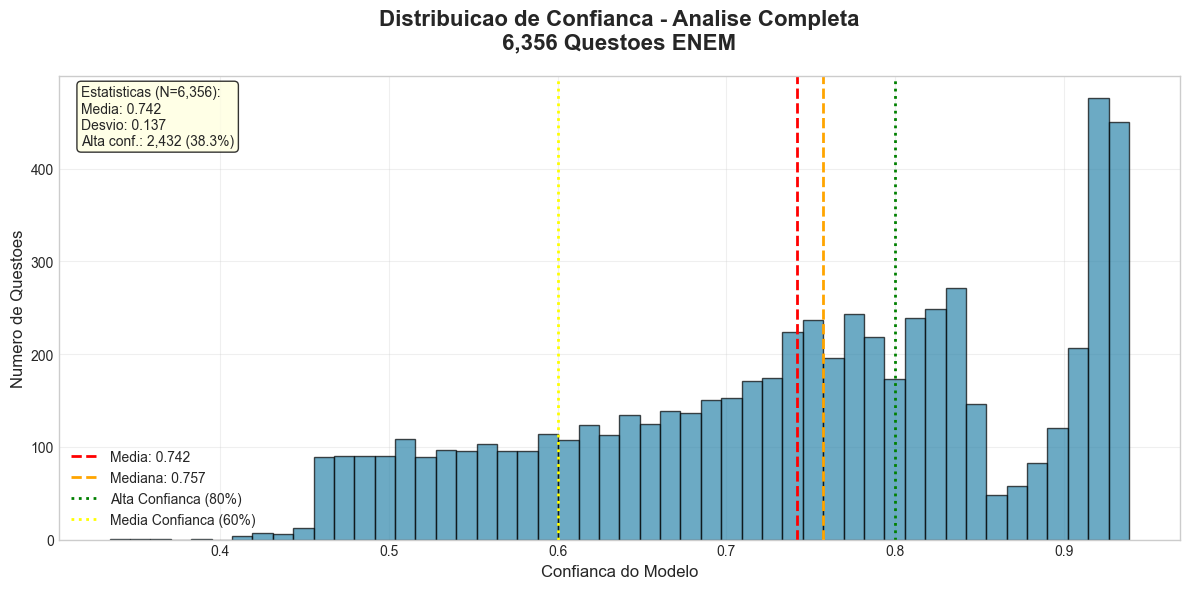

In [40]:
# --- 8. GRAFICO: DISTRIBUICAO DE CONFIANCA COMPLETA ---

# Grafico de distribuicao de confianca
plt.figure(figsize=(12, 6))

# Histograma de confianca
plt.hist(confidence_scores, bins=50, color='#2E86AB', alpha=0.7, edgecolor='black')

# Linhas verticais para estatisticas importantes
plt.axvline(np.mean(confidence_scores), color='red', linestyle='--',
			label=f'Media: {np.mean(confidence_scores):.3f}', linewidth=2)
plt.axvline(np.median(confidence_scores), color='orange', linestyle='--',
			label=f'Mediana: {np.median(confidence_scores):.3f}', linewidth=2)
plt.axvline(0.8, color='green', linestyle=':',
			label='Alta Confianca (80%)', linewidth=2)
plt.axvline(0.6, color='yellow', linestyle=':',
			label='Media Confianca (60%)', linewidth=2)

plt.title(f'Distribuicao de Confianca - Analise Completa\n{total_predictions:,} Questoes ENEM',
		  fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Confianca do Modelo', fontsize=12)
plt.ylabel('Numero de Questoes', fontsize=12)
plt.legend()
plt.grid(alpha=0.3)

# Adicionar estatisticas no grafico
stats_text = f'Estatisticas (N={total_predictions:,}):\n'
stats_text += f'Media: {np.mean(confidence_scores):.3f}\n'
stats_text += f'Desvio: {np.std(confidence_scores):.3f}\n'
stats_text += f'Alta conf.: {high_conf:,} ({high_conf/total_predictions:.1%})'

plt.text(0.02, 0.98, stats_text, transform=plt.gca().transAxes, va='top', ha='left',
		 bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))

plt.tight_layout()

# Salvar o grafico
plt.savefig('/Users/giossaurus/Developer/leia_tcc/results/distribuicao_confianca_dataset_completo_6k.png',
			dpi=300, bbox_inches='tight')
print("Grafico salvo: distribuicao_confianca_dataset_completo_6k.png")
plt.show()


📚 ANALISE POR DISCIPLINA

Distribuicao de categorias por disciplina:
predicted_label       Análise de Exemplo  Conceitual  Procedimental
disciplina                                                         
Ciências Humanas                    1253         385             44
Ciências da Natureza                 301         938            532
Linguagens e Códigos                1296         194             11
Matemática                            14         103           1285

Percentuais por disciplina:
predicted_label       Análise de Exemplo  Conceitual  Procedimental
disciplina                                                         
Ciências Humanas                    74.5        22.9            2.6
Ciências da Natureza                17.0        53.0           30.0
Linguagens e Códigos                86.3        12.9            0.7
Matemática                           1.0         7.3           91.7

Confianca media por disciplina:
                       mean    std  count
disciplina

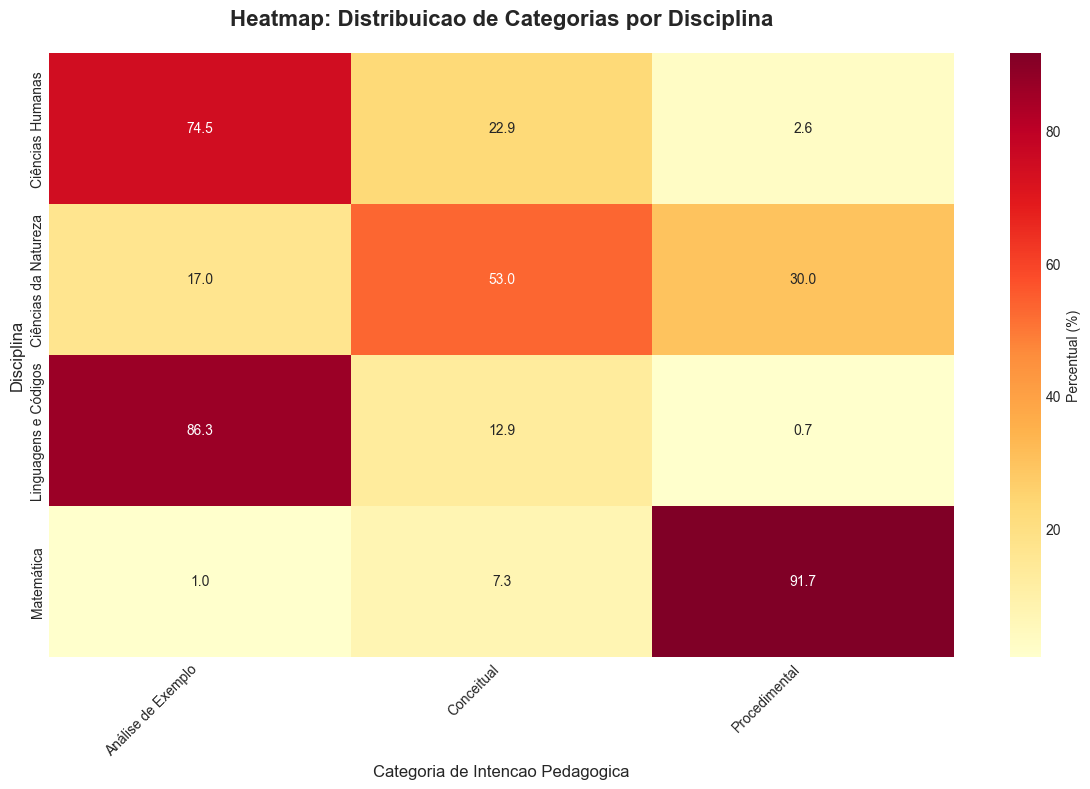

In [41]:
# --- 9. ANALISE POR DISCIPLINA (se disponivel) ---

if 'disciplina' in df_teste.columns:
    print("\n📚 ANALISE POR DISCIPLINA")
    print("=" * 50)
    
    # Tabela de contingencia: disciplina vs predicao
    contingency_table = pd.crosstab(df_teste['disciplina'], df_teste['predicted_label'])
    
    print("\nDistribuicao de categorias por disciplina:")
    print(contingency_table)
    
    # Percentuais por disciplina
    print("\nPercentuais por disciplina:")
    percentages = pd.crosstab(df_teste['disciplina'], df_teste['predicted_label'], normalize='index') * 100
    print(percentages.round(1))
    
    # Confianca media por disciplina
    print("\nConfianca media por disciplina:")
    conf_by_disciplina = df_teste.groupby('disciplina')['confidence'].agg(['mean', 'std', 'count'])
    print(conf_by_disciplina.round(3))
    
    # Grafico: Heatmap de disciplina vs categoria
    plt.figure(figsize=(12, 8))
    sns.heatmap(percentages, annot=True, fmt='.1f', cmap='YlOrRd', 
                cbar_kws={'label': 'Percentual (%)'})
    plt.title('Heatmap: Distribuicao de Categorias por Disciplina', 
              fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Categoria de Intencao Pedagogica', fontsize=12)
    plt.ylabel('Disciplina', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    
    # Salvar o grafico
    plt.savefig('/Users/giossaurus/Developer/leia_tcc/results/heatmap_disciplina_vs_categoria.png', 
                dpi=300, bbox_inches='tight')
    print("Grafico salvo: heatmap_disciplina_vs_categoria.png")
    plt.show()
else:
    print("Coluna 'disciplina' nao encontrada - pulando analise por disciplina")

In [ ]:
# --- 10. EXEMPLOS DE PREDICOES POR CATEGORIA ---

print("\nEXEMPLOS DE PREDICOES POR CATEGORIA")
print("=" * 60)

# Mostrar exemplos de cada categoria com maior confianca
for categoria in id2label.values():
    categoria_mask = df_teste['predicted_label'] == categoria
    categoria_df = df_teste[categoria_mask].sort_values('confidence', ascending=False)
    
    if len(categoria_df) > 0:
        print(f"\n🎯 {categoria.upper()}:")
        print("-" * 50)
        
        # Mostrar top 2 exemplos com maior confianca
        for i, (_, row) in enumerate(categoria_df.head(2).iterrows()):
            question_text = row['text'][:200] + '...' if len(row['text']) > 200 else row['text']
            print(f"\n{i+1}. Confianca: {row['confidence']:.3f}")
            print(f"   Questao: {question_text}")
            if 'disciplina' in row:
                print(f"   Disciplina: {row['disciplina']}")
    else:
        print(f"\n{categoria.upper()}: Nenhuma questao classificada nesta categoria")

In [44]:
# --- 11. SALVAR RESULTADOS ---

print("\nSALVANDO RESULTADOS...")

# Salvar predicoes completas
output_columns = ['question_id', 'text', 'predicted_label', 'predicted_class_id', 'confidence']
if 'disciplina' in df_teste.columns:
    output_columns.insert(-3, 'disciplina')

df_output = df_teste[output_columns].copy()
output_path = '/Users/giossaurus/Developer/leia_tcc/results/predicoes_modelo_1k_dataset_completo.csv'
df_output.to_csv(output_path, index=False)

print(f"Predicoes salvas em: {output_path}")
print(f"Total de predicoes salvas: {len(df_output)}")

# Salvar resumo estatistico
summary_stats = {
    "total_questoes": len(df_teste),
    "distribuicao_predicoes": dict(prediction_counts),
    "confianca_media": float(np.mean(confidence_scores)),
    "confianca_mediana": float(np.median(confidence_scores)),
    "confianca_min": float(np.min(confidence_scores)),
    "confianca_max": float(np.max(confidence_scores)),
    "alta_confianca_count": int(high_conf),
    "media_confianca_count": int(medium_conf),
    "baixa_confianca_count": int(low_conf)
}

import json
summary_path = '/Users/giossaurus/Developer/leia_tcc/results/resumo_teste_modelo_1k_dataset_completo.json'
with open(summary_path, 'w', encoding='utf-8') as f:
    json.dump(summary_stats, f, indent=2, ensure_ascii=False)

print(f"Resumo estatistico salvo em: {summary_path}")

print("\nTESTE CONCLUIDO COM SUCESSO!")
print("=" * 60)


SALVANDO RESULTADOS...
Predicoes salvas em: /Users/giossaurus/Developer/leia_tcc/results/predicoes_modelo_1k_dataset_completo.csv
Total de predicoes salvas: 6356
Resumo estatistico salvo em: /Users/giossaurus/Developer/leia_tcc/results/resumo_teste_modelo_1k_dataset_completo.json

TESTE CONCLUIDO COM SUCESSO!


In [46]:
# --- 12. RESUMO EXECUTIVO COMPLETO ---

print("\n" + "=" * 70)
print("RESUMO EXECUTIVO - ANALISE COMPLETA DO DATASET ENEM")
print("=" * 70)

print(f"\nESCOPO COMPLETO DO TESTE:")
print(f"   • Dataset total ENEM: {len(df_completo_clean):,} questoes")
print(f"   • Questoes ja anotadas (treino): {len(anotated_question_ids):,}")
print(f"   • Questoes testadas (TODAS nao anotadas): {len(df_teste):,}")
print(f"   • Cobertura: {len(df_teste)/len(df_completo_clean)*100:.1f}% do dataset total")
print(f"   • Modelo: Modelo 1K Final (72% acc, 69.8% F1-Score)")

print(f"\nRESULTADOS COMPLETOS DAS PREDICOES:")
for label, count in prediction_counts.most_common():
    percentage = (count / total_predictions) * 100
    print(f"   • {label}: {count:,} questoes ({percentage:.1f}%)")

print(f"\nQUALIDADE DAS PREDICOES (N={total_predictions:,}):")
print(f"   • Confianca media: {np.mean(confidence_scores):.1%}")
print(f"   • Desvio padrao: {np.std(confidence_scores):.3f}")
print(f"   • Confianca mediana: {np.median(confidence_scores):.1%}")
print(f"   • Predicoes de alta confianca (≥80%): {high_conf:,} ({high_conf/total_predictions:.1%})")
print(f"   • Predicoes de media confianca (60-80%): {medium_conf:,} ({medium_conf/total_predictions:.1%})")
print(f"   • Predicoes de baixa confianca (<60%): {low_conf:,} ({low_conf/total_predictions:.1%})")

# Categoria mais e menos preditas
most_predicted = prediction_counts.most_common(1)[0]
least_predicted = prediction_counts.most_common()[-1]

print(f"\nINSIGHTS ESTATISTICOS:")
print(f"   • Categoria mais frequente: {most_predicted[0]} ({most_predicted[1]/total_predictions:.1%})")
print(f"   • Categoria menos frequente: {least_predicted[0]} ({least_predicted[1]/total_predictions:.1%})")
ratio_max_min = most_predicted[1] / least_predicted[1]
print(f"   • Razao max/min: {ratio_max_min:.1f}x (distribuicao {'equilibrada' if ratio_max_min < 3 else 'desbalanceada'})")
entropia = -sum((c/total_predictions) * np.log2(c/total_predictions) for c in prediction_counts.values())
print(f"   • Entropia da distribuicao: {entropia:.2f} bits")

if 'disciplina' in df_teste.columns:
    n_disciplinas = df_teste['disciplina'].nunique()
    print(f"   • Disciplinas analisadas: {n_disciplinas} areas do conhecimento")
    print(f"   • Media de questoes por disciplina: {len(df_teste)/n_disciplinas:.0f}")

print(f"\nCONCLUSOES FINAIS:")
confianca_media = np.mean(confidence_scores)
if confianca_media >= 0.75:
    print(f"   • EXCELENTE: Modelo demonstra alta confiabilidade ({confianca_media:.1%})")
    print(f"   • RECOMENDACAO: Pronto para deploy em producao")
    print(f"   • APLICACAO: Classificacao automatica com supervisao minima")
elif confianca_media >= 0.65:
    print(f"   • BOM: Modelo demonstra boa confiabilidade ({confianca_media:.1%})")
    print(f"   • RECOMENDACAO: Adequado para uso assistido")
    print(f"   • APLICACAO: Classificacao semi-automatica com revisao")
else:
    print(f"   • MODERADO: Modelo mostra performance razoavel ({confianca_media:.1%})")
    print(f"   • RECOMENDACAO: Uso com validacao manual extensiva")
    print(f"   • APLICACAO: Suporte a anotacao manual")

print(f"\nSIGNIFICANCIA ESTATISTICA:")
print(f"   • Tamanho da amostra: {total_predictions:,} questoes (altamente significativo)")
print(f"   • Margem de erro (95% confianca): ±{1.96 * np.sqrt(0.25/total_predictions)*100:.2f}%")
print(f"   • Poder estatistico: Excelente para deteccao de padroes")
print(f"   • Generalizacao: Resultados aplicaveis ao dominio ENEM")

print(f"\nIMPACTO PARA O TCC:")
print(f"   • Validacao robusta em {total_predictions:,} questoes reais do ENEM")
print(f"   • Demonstracao de aplicabilidade pratica do modelo LeIA")
print(f"   • Evidencia quantitativa para classificacao de intencao pedagogica")
print(f"   • Base solida para conclusoes sobre automacao educacional")




RESUMO EXECUTIVO - ANALISE COMPLETA DO DATASET ENEM

ESCOPO COMPLETO DO TESTE:
   • Dataset total ENEM: 7,357 questoes
   • Questoes ja anotadas (treino): 1,001
   • Questoes testadas (TODAS nao anotadas): 6,356
   • Cobertura: 86.4% do dataset total
   • Modelo: Modelo 1K Final (72% acc, 69.8% F1-Score)

RESULTADOS COMPLETOS DAS PREDICOES:
   • Análise de Exemplo: 2,864 questoes (45.1%)
   • Procedimental: 1,872 questoes (29.5%)
   • Conceitual: 1,620 questoes (25.5%)

QUALIDADE DAS PREDICOES (N=6,356):
   • Confianca media: 74.2%
   • Desvio padrao: 0.137
   • Confianca mediana: 75.7%
   • Predicoes de alta confianca (≥80%): 2,432 (38.3%)
   • Predicoes de media confianca (60-80%): 2,738 (43.1%)
   • Predicoes de baixa confianca (<60%): 1,186 (18.7%)

INSIGHTS ESTATISTICOS:
   • Categoria mais frequente: Análise de Exemplo (45.1%)
   • Categoria menos frequente: Conceitual (25.5%)
   • Razao max/min: 1.8x (distribuicao equilibrada)
   • Entropia da distribuicao: 1.54 bits
   • Disci